<a href="https://colab.research.google.com/github/50-Course/swarm-optimizers/blob/main/XXXXXX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt

from fractions import Fraction
import math

In [50]:
# FUNCTION IMPLEMENTATIONS

# Arguments:
# x: A numpy array (decision vector) containing the following variables:
#     x[0]: The tensile space.
#     x[1]: The oil pressure.
#     x[2]: The oil temperature rise.
#     x[3]: The oil film thickness.
#     x[4]: The step radius.
#     x[5]: The recess radius.
#     x[6]: The viscosity of the oil.
#     x[7]: The contact pressure.

def P(x):
  return (np.log10(np.log10(8.122 * x[3] + 0.8)) - 10.04) / -3.55

def W(x):
  """Calculates the load carrying capacity.

  Args:
    x: A
      x[0]: The inlet pressure.
      x[1]: The outlet pressure.
      x[2]: The oil thickness.
      x[3]: The viscosity of the oil.

  Returns:
    The load carrying capacity.
  """

  return (np.pi * P0(x) / 2) * ((x[3]**2 - x[2]**2) / np.log(x[2] / x[1]))

def P0(x):
  """Calculates the inlet pressure.

  Args:
    x: A NumPy array containing the following variables:
      x[0]: The inlet pressure.
      x[1]: The outlet pressure.
      x[2]: The oil thickness.
      x[3]: The viscosity of the oil.

  Returns:
    The inlet pressure.
  """
  return ((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1])

def Ef(x):
  """Calculates the friction loss.

  Args:
    x: A NumPy array containing the following variables:
      x[0]: The inlet pressure.
      x[1]: The outlet pressure.
      x[2]: The oil thickness.
      x[3]: The viscosity of the oil.

  Returns:
    The friction loss.
  """

  return 143.308 * delta_t(x)*x[0]

def delta_t(x):
  return 2 * (np.power(10, P(x)) - 560)

def f(x):

  minimums = np.minimum(((P0(x) * x[0] / 0.7) + Ef(x)), x)
  return minimums


def h(x):
  """Calculates the oil thickness.

  Args:
    x: A NumPy array containing the following variables:
      x[0]: The inlet pressure.
      x[1]: The outlet pressure.
      x[2]: The oil thickness.
      x[3]: The viscosity of the oil.

  Returns:
    The oil thickness.
  """

  return ((1500 * np.pi / 60)**2) * (2e-6 * np.pi * x[3] / Ef(x)) * ((x*Fraction(4, 3) / 4) - (x*Fraction(4, 2) / 4))

def g1(x):
  """Calculates the first constraint function."""
  return 101000 - W(x)

def g2(x):
  """Calculates the second constraint function."""
  return P0(x) - 1000

def g3(x):
  """Calculates the third constraint function."""
  return delta_t(x) - 50

def g4(x):
  """Calculates the fourth constraint function."""
  return 0.001 - h(x)

def g5(x):
  """Calculates the fifth constraint function."""
  return x[1] - x[2]

def g6(x):
  """Calculates the sixth constraint function."""
  return ((0.0307 * x[0]) / (772.8 * np.pi * P0(x) * h(x) * x[2])) - 0.001

def g7(x):
  """Calculates the seventh constraint function."""

  return (W(x) / np.pi * (x*Fraction(2, 3) - x*Fraction(2, 2))) - 5000

In [102]:
# RANDOM SEARCH IMPLEMENTATION
def random_search(f, x_array, seed=np.random.seed(48), lb=1, ub=16, max_evals=10_000, constraint_functions=[]):
    """
    f: objective function to be optimized
    seed: random seed for reproducibility
    lb: lower bound of our search space
    ub: upper bound of our search space
    max_evals: maximum number of evaluations
    """

    np.random.seed(seed)

    best_x = None
    best_f = np.inf

    # Ensure we working with array at all times (just a little safeguard)
    search_space = np.array(x_array)

    evals = 0 # number of evaluations

    # loop until max_evals
    while evals < max_evals:
        # generate random x
        x = np.random.uniform(search_space, size=len(x_array))

        x = np.clip(x, lb, ub)

        # check if constraint is satisfied
        constraints = [g(x) for g in constraint_functions]
        if np.all(c<= 0 for c in constraints):
          fx = f(x)

          # update best_x and best_f if necessary
          if np.all(fx < best_f):
              best_x = x
              best_f = fx
          # increment evals
          evals += 1

    return best_x, best_f


In [103]:
# SIMULATED ANNEALING IMPLEMENTATION

def simulated_annealing(f, initial_solution, seed=np.random.seed(48), max_iterations=10_000, control_parameter=1):
    """
    f: objective function to be optimized
    seed: random seed for reproducibility
    initial_solution: initial solution from which we start our search (this comes from our random search)
    max_iterations: maximum number of iterations (stop criterion)
    control_parameter: control parameter for simulated annealing (temperature)
    """

    cool_rate = 0.95

    np.random.seed(seed)

    current_solution = initial_solution
    current_value = f(current_solution)

    best_solution = current_solution
    best_value = current_value

    for _ in range(max_iterations):
        # Generate a new solution
        neighbour_solution = current_solution + np.random.uniform(0, 1) # Keeping our new decision space within our constraints
        neighbour_value = f(neighbour_solution)

        # Accept or reject the new solution based on acceptance probability
        acceptance_prob = accept_p(neighbour_value, current_value, control_parameter)
        if np.random.rand() < acceptance_prob:
            current_solution = neighbour_solution
            current_value = neighbour_value

        # Update the best solution if the current solution is better
        if current_value < best_value:
            best_solution = current_solution
            best_value = current_value

        # Cool the temperature
        control_parameter *= cool_rate

    return best_solution, best_value

def accept_p(neighbour_solution, current_solution, control_parameter):
    """
    Acceptance probability for the Simulated annealing method.

    neighbour_solution: new solution
    current_solution: current solution
    control_parameter: control parameter for simulated annealing (temperature)
    """
    if np.any(neighbour_solution < current_solution):
        return 1  # accept new solution
    else:
        return np.exp(-(neighbour_solution - current_solution) / control_parameter)  # accept new solution with probability

In [106]:
# VALIDATION CODE

x = np.array([4.19, 11.57, 6.69, 10.65])

print("Objective function output, f(x) = ", f(x))
print("Constraint function output, g1(x) = ", g1(x))
print("Constraint function output, g2(x) = ", g2(x))
print("Constraint function output, g3(x) = ", g3(x))
print("Constraint function output, g4(x) = ", g4(x))
print("Constraint function output, g5(x) = ", g5(x))
print("Constraint function output, g6(x) = ", g6(x))
print("Constraint function output, g7(x) = ", g7(x))

constraint_functions = [g1, g2, g3, g4, g5, g6, g7]
# test the random search
best_x, best_f = random_search(f, x, seed=420, max_evals=10_000, constraint_functions=constraint_functions)


Objective function output, f(x) =  [-66258374.6794144 -3148598.097346256 -16279475.07768886
 -4036587.029849999]
Constraint function output, g1(x) =  [-2179384118.4763093 -103412239.44704632 -535347398.0628562
 -132622294.57011858]
Constraint function output, g2(x) =  [-11070120.148375956 -526720.7193908262 -2720423.317538755
 -675072.0923628119]
Constraint function output, g3(x) =  -52.97118117373543
Constraint function output, g4(x) =  [0.0008384308579466824 0.0005538532282680466 0.0007420292218766839
 0.0005893290303418061]
Constraint function output, g5(x) =  4.88
Constraint function output, g6(x) =  [-0.0010000044283075384 -0.0010000337657535443 -0.0010000112891687231
 -0.001000028609412784]
Constraint function output, g7(x) =  [-968944818.4687054 -127079418.6640295 -380082896.57763827
 -149982335.59936023]


In [78]:
# TESTING, TESTING, LET'S SEE IF OUR CONSTRAINTS WERE THROUGHLY WORKING
# You would have to run this a few times to get the desired results, this is to solely test fully randomized values
# within search space given by our constraint functions

def validate_constraints():
    # Generate random decision vector within [1, 16]
    decision_vector = np.random.uniform(1, 16, 4)
    print(decision_vector)

    decision_vector = np.array(decision_vector)
    # Check each constraint
    for g in [ g1, g2, g3, g4, g5, g6, g7]:
        result = g(decision_vector)
        print(result)
        assert np.all(result <= 16), f"Constraint {g.__name__} is not less than or equal to 16."

validate_constraints()

[ 6.9215797   7.51459555 13.99021536  6.74825204]
[-22287759575440.72 -17416675234904.268 -2699037216884.9146
 -24049619087514.85]
[-58716799241.71787 -45883994123.84854 -7110577923.917389
 -63358394045.43703]
-18.99480537587715
[0.00100981058214954 0.0010106511172463305 0.0010198296000268037
 0.0010095649091527697]
-6.4756198089149235
[-0.0009999999891396189 -0.0009999999871989427 -0.0009999999556306138
 -0.0009999999896767317]
[-16368184551319.973 -13886721948150.867 -4006472463785.881
 -17219810647901.156]


In [107]:
# Perform random search and simulated annealing simulations, 21 times
search_results = [random_search(f, x, seed=i, constraint_functions=constraint_functions) for i in range(21)]


In [108]:
selected = search_results[0][1] # Could be vector from our search result
print(selected)

[-2485127103557136.0 -1.3689958442495283e+17 -1243049197536691.5
 -5.379896296762006e+16]


In [112]:
sa_results = (-0.9891172937981292, 0.00011843329427618787)
print(sa_results)

(-0.9891172937981292, 0.00011843329427618787)


In [109]:
print(search_results)

[(array([4.07129679, 1.06999461, 5.12884443, 1.4608008 ]), array([-2485127103557136.0, -1.3689958442495283e+17, -1243049197536691.5,
       -5.379896296762006e+16], dtype=object)), (array([3.03623693, 1.0880015 , 5.75665322, 1.01212254]), array([-6485521026898226.0, -1.4094944507512322e+17, -951571974269462.4,
       -1.7508645723586557e+17], dtype=object)), (array([3.84438326, 1.13921369, 4.78684341, 1.00771266]), array([-9115171437503104.0, -3.502912472813047e+17, -4721687195543037.0,
       -5.0609812607241043e+17], dtype=object)), (array([3.97151182, 1.1556537 , 4.02458381, 1.12688564]), array([-5419365521973813.0, -2.1995451399008234e+17, -5207785597176550.0,
       -2.3723375706271978e+17], dtype=object)), (array([3.92989749, 1.42617711, 5.38981445, 1.03891672]), array([-7817708321276711.0, -1.635696562023054e+17, -3030412056845819.0,
       -4.231369251851768e+17], dtype=object)), (array([3.80693754, 1.02622514, 2.14786889, 1.15282906]), array([-2690409915647804.5, -1.3734655113

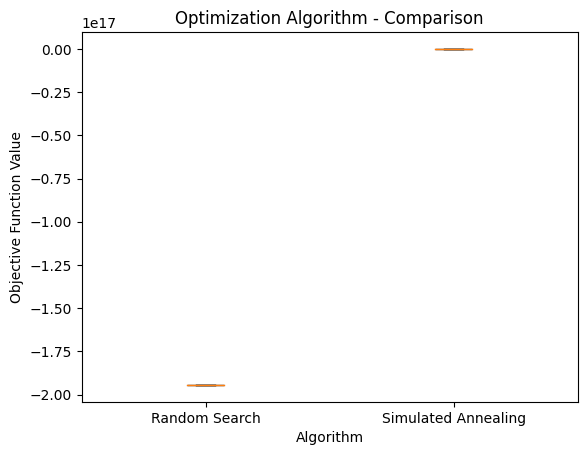

In [116]:
# GRAPH PLOTTING

# Generic plotting method that takes in results from a
# Simulated Annealing process and a random search and
# plot both results on a pretty 2D-Canvas
def plot_graph(search_results, sim_results) -> None:
    data = [search_results, sim_results]
    labels = ['Random Search', 'Simulated Annealing']

    fig, ax = plt.subplots()
    ax.boxplot(data, vert=True, patch_artist=True, labels=labels)

    ax.set_title('Optimization Algorithm - Comparison')
    ax.set_ylabel('Objective Function Value')
    ax.set_xlabel('Algorithm')

    plt.show()

plot_graph(search_results=[-2485127103557136.0 -1.3689958442495283e+17 -1243049197536691.5
 -5.379896296762006e+16], sim_results=sa_results)